<font size="6">Trading Algorithm Optimization for ARIMA Prediction Models</font>



Scott Griffin
November 29th, 2023



# Background, our ARIMA model

Recreating Adebiyi, Adewumi, and Ayoa's 2014 paper titled Stock Price Prediction Using the ARIMA Model, we found positive return can be generated by fitting an ARIMA model with parameters (2,1,0) on Nokia (NOK) daily stock prices.

We then implemented the model into a simple trading algorithm which generated a small annual return of 0.099% with arbitrarily-chosen intitial parameters over the same backtesting period used in Adebiyi, Adewumi, and Ayoa's experiment.

# Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from pandas import read_csv, DataFrame
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from sklearn.metrics import r2_score
import numpy as np
import random

In [4]:
datasets_path = '/content/drive/MyDrive/Fall_23_Fin_Thesis/datasets'
nokia_data = '/NOK_daily_19950425_20110225.csv'
series = read_csv(datasets_path + nokia_data, header=0, index_col=0, parse_dates=True)

# Trading algorithm

In [5]:
def run_arima_trading_algorithm(series, train_size, arima_order, change_to_warrant_trade, trade_horizon, shares_per_trade):
  '''
  series: Pandas dataframe of daily prices and dates
  train_size: Percent of data to train model on before starting trades
  arima_order: ARIMA model parameters to use
  change_to_warrant_trade: Threshold of % difference between predicted future price and today's price to trigger a trade
  trade_horizon: Days to hold trading position for before closing that position
  shares_per_trade: Number of shares to buy/short for each trade
  '''
  account_path = []
  account = 10000000
  long_count = 0
  short_count = 0
  X = series.values
  size = int(len(X) * train_size)
  train, test = X[0:size], X[size:]
  history = [x for x in train]
  predictions = []
  len_test = len(test)
  for i in range(len_test-trade_horizon):
    model = tsa.ARIMA(history, order=arima_order)
    model_fit = model.fit()
    output = model_fit.forecast(trade_horizon)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[i]
    if (abs(yhat-obs)/obs) >= change_to_warrant_trade:
      if yhat < obs: #short
        short_count += 1
        profit = (obs[0] - test[i+trade_horizon][0])*shares_per_trade
        account += profit
      else: #long
        long_count += 1
        profit = (test[i+trade_horizon][0] - obs[0])*shares_per_trade
        account += profit
    history.append(obs)
    account_path.append(account)
  return account_path

###Helper functions

In [6]:
def arima_trading_algorithm_final_account_value(test_series, trade_horizon, trade_horizon_predictions, change_to_warrant_trade):
  shares_per_trade = 10000
  account = 10000000
  trade_count = 0
  profitable_trade_count = 0
  X = series.values
  len_test = len(test_series)
  for i in range(len_test-trade_horizon):
    yhat = trade_horizon_predictions[i]
    obs = test_series[i][0]
    if (abs(yhat-obs)/obs) >= change_to_warrant_trade:
      if yhat < obs: # short
        trade_count += 1
        profit = (obs - test_series[i+trade_horizon][0])*shares_per_trade
        account += profit
      else: # long
        trade_count += 1
        profit = (test_series[i+trade_horizon][0] - obs)*shares_per_trade
        account += profit
      if profit > 0:
        profitable_trade_count += 1
  return (account, trade_count, profitable_trade_count)

def generate_arima_predictions(series, train_size, arima_order, trade_horizons):
    X = series.values
    size = int(len(X) * train_size)
    train, test = X[:size], X[size:]
    history = [x for x in train]
    predictions = {}
    for trade_horizon in trade_horizons:
      predictions[trade_horizon] = []
    len_test = len(test)
    for i in range(len_test):
      print(f"{i}/{len_test}")
      model = tsa.ARIMA(history, order=arima_order)
      model_fit = model.fit()
      for trade_horizon in trade_horizons:
        predictions[trade_horizon].append(model_fit.forecast(trade_horizon)[0])
      obs = test[i]
      history.append(obs)
    return predictions

def arima_trading_algorithm_return_path(test_series, trade_horizon, trade_horizon_predictions, change_to_warrant_trade):
  account_path = []
  shares_per_trade = 10000
  account = 10000000
  trade_count = 0
  profitable_trade_count = 0
  len_test = len(test_series)
  for i in range(len_test-trade_horizon):
    yhat = trade_horizon_predictions[i]
    obs = test_series[i][0]
    if (abs(yhat-obs)/obs) >= change_to_warrant_trade:
      if yhat < obs: # short
        trade_count += 1
        profit = (obs - test_series[i+trade_horizon][0])*shares_per_trade
        account += profit
      else: # long
        trade_count += 1
        profit = (test_series[i+trade_horizon][0] - obs)*shares_per_trade
        account += profit
      if profit > 0:
        profitable_trade_count += 1
    account_path.append(account)
  if trade_count == 0:
    profitable_trade_ratio = 0
  else:
    profitable_trade_ratio = round(profitable_trade_count/trade_count,2)
  return (account_path, trade_count, profitable_trade_ratio)

def effective_annual_return(start_value, end_value, days):
  return round((((end_value / start_value) ** (360/days)) - 1)*100,4)

# Problem formulation

\begin{align*}
\text{Maximize} \quad & \sum_{i=0}^{N-\text{t}} \left[( P_{i+\text{t}} - P_i   \right) \cdot \text{Long}({t,c,i}) + \left( P_i - P_{i+\text{t}} \right) \cdot \text{Short}({t,c,i})] \\
& \text{Long}({t,c,i}) = \begin{cases}
1 & \text{if } \left(\text{Pred}_{\text {t},i} - P_i \right) / P_i \geq \text{c} \\
0 & \text{otherwise}
\end{cases} \\
& \text{Short}({t,c,i}) = \begin{cases}
1 & \text{if } \left( \text P_i - {Pred}_{\text {t},i} \right) / P_i \geq \text{c} \\
0 & \text{otherwise}
\end{cases} \\
\ \text{s.t.} \quad & \text{t} \in \mathbb{Z} \\
& \text{c} \geq 0 \\
\end{align*}

Where

$t$ is $\text{trade_horizon}$, the trade horizon for all predictions and trades made by the algorithm.

$c$ is $\text{change_to_warrant_trade}$, the percentage difference required between a future predicted price and a current observed price to trigger a long or short trade.

$P_i$ is the observed price at time $i$

$P_{i+t}$ is the observed future price at time $i+t$

$Pred_{\text {t},i}$ is the ARIMA model prediction at time $i$ for a future price at time $i+t$.

$N$ = length($P$)




# Pyomo, Gurobi non-linear optimization attempt

## Pregenerate predictions $Pred$

In [7]:
# parameters
arima_order = (2,1,0)
train_size = .66
trade_horizons = trade_horizon_list = [1,3,5,10,20]
file_path = datasets_path + "/time_horizon_predictions.csv"

# generate predictions
predictions_saved = True
if not predictions_saved:
  predictions = generate_arima_predictions(series,train_size,arima_order,trade_horizons)
  predictions = pd.DataFrame(predictions)
  predictions.to_csv(file_path, index=False)
predictions = pd.read_csv(file_path).to_dict(orient='list')
predictions = {int(key): value for key, value in predictions.items()}

## Pyomo model

In [8]:
!pip install pyomo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.5 MB/s eta 0:00:00


In [ ]:
import pyomo.environ as pyo
import random

changes_to_warrant_trade = [.01,.05]
X = series.values
size = int(len(X) * train_size)
P = X[size:len(X)]
Pred = predictions

N = len(P)

model = pyo.ConcreteModel()
model.trade_horizon = pyo.Var(bounds=(1, 5), within=pyo.NonNegativeIntegers, initialize=random.randint(1, 5))
model.change_to_warrant_trade = pyo.Var(bounds=(0,1), within=pyo.NonNegativeReals, initialize=random.uniform(0, 1))
model.I = pyo.RangeSet(0, N-1)
trade_horizon_values = list(Pred.keys())
model.Horizons = pyo.Set(initialize=trade_horizon_values)
model.P = pyo.Param(model.I, initialize=lambda model, i: P[i])
model.Pred = pyo.Param(model.I, model.Horizons, within=pyo.Any,
                       initialize=lambda model, i, h: Pred[h][i] if i < len(Pred[h]) else 0)

print(f"Initial parameters: {model.trade_horizon.value}, {model.change_to_warrant_trade.value}")

def objective_rule(model):
    total_profit = 0
    h = int(pyo.value(model.trade_horizon))
    c = float(pyo.value(model.change_to_warrant_trade))
    for i in model.I:
        if i + h <= N-1:
            P_i = model.P[i]
            P_future = model.P[i + h]
            Pred_i_h = model.Pred[i, h]
            long_position = 1 if (Pred_i_h - P_i) / P_i >= c else 0
            short_position = 1 if (P_i - Pred_i_h) / P_i >= c else 0
            total_profit += (P_future - P_i) * long_position + (P_i - P_future) * short_position
    return total_profit[0]

model.profit = pyo.Objective(rule=objective_rule, sense=pyo.maximize)
solver = pyo.SolverFactory('gurobi')
solver.options['MIPFocus'] = 3
solver.options['Heuristics'] = 1
solver.options['ImprovementStartNodes'] = 100
solver.options['PopulationSize'] = 200
solver.options['BranchDir'] = -1
solver.options['SolutionLimit'] = 10
solver.options['NonConvex'] = 2
solver.options['NodefileStart'] = 0.5
solver.options['TimeLimit'] = 3600

result = solver.solve(model)
print('Trade horizon: ', pyo.value(model.trade_horizon))
print('Change to warrant trade: ', pyo.value(model.change_to_warrant_trade))
print('Profit: ', pyo.value(model.profit))
model.solutions.load_from(result)
if result.solver.status == pyo.SolverStatus.ok and result.solver.termination_condition == pyo.TerminationCondition.best:
    print('Found the optimal solution')
else:
    print('Something is wrong:', result.solver.status, result.solver.termination_condition)

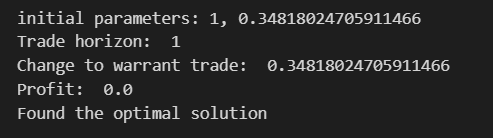

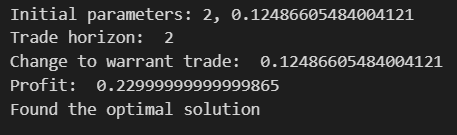

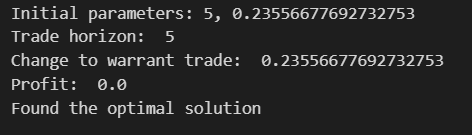

<h3>We couldn't get a good result with Gurobi's nonlinear optimization software imported into pyomo. I think a possibility is that the Gurobi solver cant find which could either be due to me not understanding Pyomo.

direction to search in given the initial parameters, even when we tweaked its settings. This is a problem.

# Brute-force solution

<h3>The simplest approach at this point is to calculate all results for a set of parameter values and compare them to find the maximum.

In [10]:
arima_order = (2,1,0)
shares_per_trade = 10000
train_size = .66
X = series.values
size = int(len(X) * train_size)
test_series = X[size:]
change_to_warrant_trade_list = []
trade_horizons = []
for i in range(1000): # 1000 x 100 = 100,000 combinations
  change_to_warrant_trade_list.append(i/1000)
  if i == 0 or i > 100:
    continue
  trade_horizons.append(i)

In [ ]:
predictions = generate_arima_predictions(series, train_size, arima_order, trade_horizons)

In [12]:
predictions_save = predictions.copy()

In [13]:
predictions = predictions_save.copy()

In [ ]:
account_values = {}
for change_to_warrant_trade in change_to_warrant_trade_list:
  for trade_horizon in trade_horizons:
    print(f"running {change_to_warrant_trade},{trade_horizon}")
    account_values[(change_to_warrant_trade,trade_horizon)] = arima_trading_algorithm_return_path(test_series, trade_horizon, predictions[trade_horizon], change_to_warrant_trade)

In [15]:
test_save = test_series.copy()
account_values_save = account_values.copy()

In [38]:
test = test_save.copy()
account_values = account_values_save.copy()

(c, t): 	final value 	trade count 	profit ratio 	annualized return (%)
-------------------------------------------------------------------------------
(0.004, 18): 	11236576 	1112 		0.52 		3.1413
(0.001, 18): 	11221059 	1275 		0.52 		3.1035
(0.002, 18): 	11155759 	1214 		0.51 		2.944
(0.0, 18): 	11153660 	1339 		0.51 		2.9389
(0.005, 18): 	11075576 	1049 		0.51 		2.7472
(0.004, 19): 	11040751 	1111 		0.51 		2.6614
(0.0, 15): 	11015502 	1342 		0.49 		2.5991
(0.001, 19): 	10974734 	1274 		0.51 		2.4982


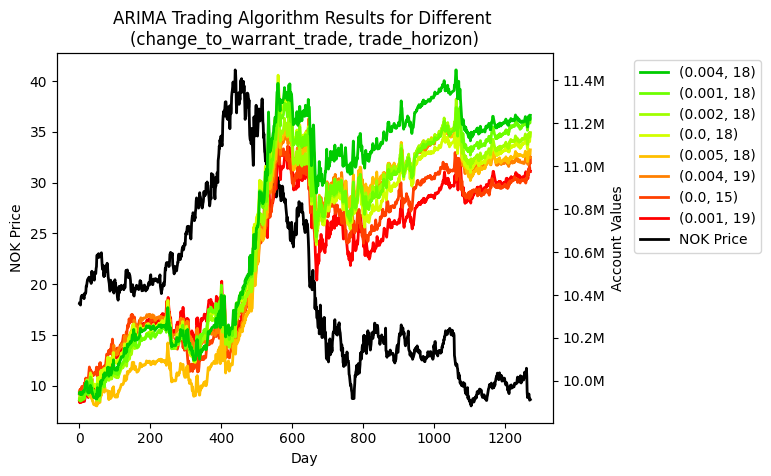

In [39]:
print("(c, t): \tfinal value \ttrade count \tprofit ratio \tannualized return (%)")
print("-------------------------------------------------------------------------------")
terminal_account_values = {}
for parameter_set in account_values.keys():
  terminal_account_values[parameter_set] = account_values[parameter_set][0][-1]
terminal_account_values = sorted(terminal_account_values.items(), key=lambda item: item[1], reverse=True)
ranked_terminal_account_values = {key: rank for rank, (key, value) in enumerate(terminal_account_values, start=1)}
top_5 = {}
for parameter_set in list(ranked_terminal_account_values.keys())[:8]:
  top_5[parameter_set] = account_values[parameter_set]
account_values = top_5
i = 0
len_test_series = len(test_series)
for parameter_set in account_values:
  last_value = round(account_values[parameter_set][0][-1])
  trade_count = account_values[parameter_set][1]
  profit_ratio = account_values[parameter_set][2]
  annual_return = effective_annual_return(10000000, last_value, len_test_series)
  print(f"{parameter_set}: \t{last_value} \t{trade_count} \t\t{profit_ratio} \t\t{annual_return}")
  i+=1
max_trade_horizon = max(trade_horizons)
for parameter_set in account_values.keys():
  trade_horizon = parameter_set[1]
  account_values[parameter_set] = (account_values[parameter_set][0][max_trade_horizon - trade_horizon:], account_values[parameter_set][1], account_values[parameter_set][2])
test = test[max_trade_horizon:]

usable_colors = ['#ff0000', '#ff4000', '#ff8000', '#ffbf00', '#d2ff00', '#a0ff00', '#6dff00', '#00cc00']
fig, ax1 = plt.subplots()
line_thickness = 2
x_values = np.arange(len(test))
ax1.plot(x_values, test, label='NOK Price', color='black', linewidth=line_thickness)
ax1.set_ylabel('NOK Price', color='black')
ax1.tick_params(axis='y', labelcolor='black')
color = 0
ax2 = ax1.twinx()
for parameter_set in reversed(account_values.keys()):
  ax2.plot(x_values, account_values[parameter_set][0], label=f'{parameter_set}', color=usable_colors[color], linewidth=line_thickness)
  color += 1
ax1.set_xlabel('Day')
ax2.set_ylabel('Account Values')
ax2.tick_params(axis='y')

def millions_formatter(x, pos):
    return f'{x / 1e6}M'
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax2.legend(list(reversed(lines)), list(reversed(labels)), loc='upper left', bbox_to_anchor=(1.15,1))

plt.title('ARIMA Trading Algorithm Results for Different \n(change_to_warrant_trade, trade_horizon)')
plt.show()

# Gradient descent algorithm solution

<h3> We can try to find a set of near-optimal solutions faster than brute-force by implementing an optimization algorithm that searches to find a local minima by comparing objective function values for randomly selected parameters and their surrounding parameters.

In [40]:
def gradient_descent_trading_algorithm_optimizer(trading_algorithm, test_series, predictions, trade_horizon_range, change_to_warrant_trade_range, learning_rate=3, num_iterations=100, idle_stop_limit=None, delta_trade_horizon=.5, delta_change_to_warrant_trade=.123, delta_randomness=.001, initial_searches = 4):

    # intitialize
    path = []
    best_parameters=((),0)
    iterations_since_best_found = 0
    original_learning_rate = learning_rate

    # pick first parameters
    trade_horizon = random.randint(trade_horizon_range[0],trade_horizon_range[1])
    change_to_warrant_trade = random.uniform(change_to_warrant_trade_range[0], change_to_warrant_trade_range[1])
    delta_trade_horizon_static = delta_trade_horizon * (trade_horizon_range[1] - trade_horizon_range[0])
    delta_change_to_warrant_trade_static = delta_change_to_warrant_trade * (change_to_warrant_trade_range[1] - change_to_warrant_trade_range[0])
    history = []
    history.append((trade_horizon, change_to_warrant_trade))

    for i in range(num_iterations):
      # new deltas
      delta_trade_horizon = round(random.uniform(1, delta_trade_horizon_static))
      delta_change_to_warrant_trade = random.uniform(.0001, delta_change_to_warrant_trade_static)
      # run current parameters
      account_current, trade_count_current, profitable_trade_count_current = trading_algorithm(test_series, trade_horizon, predictions[trade_horizon], change_to_warrant_trade)
      if trade_count_current == 0: # if no trades then make max change_to_warrant_trade half as big (hacky solution to try to cut off parameter_sets unlikely to be max)
        change_to_warrant_trade_range[1] = change_to_warrant_trade_range[1] - (change_to_warrant_trade_range[1] - change_to_warrant_trade) / 2
      if account_current > best_parameters[1]: # new best parameters found
        best_parameters = ((change_to_warrant_trade, trade_horizon), account_current)
        iterations_since_best_found = 0
      profitable_trade_ratio = 0 if trade_count_current == 0 else profitable_trade_count_current/trade_count_current
      path.append(((change_to_warrant_trade, trade_horizon), account_current, trade_count_current, profitable_trade_ratio))
      print(f"iter {i}/{num_iterations}: ({round(change_to_warrant_trade,3)}, {trade_horizon}) {account_current}")
      # vary both parameters at the same time - calculate a direction in the parameters space

      #    (a)        (b)     change
      #      \        /       to
      #       (current)       warrant
      #       /       \       trade
      #    (c)        (d)
      #
      #     trade horizon

      # calculate gradient
      trade_horizon_plus = min(round(trade_horizon + delta_trade_horizon), trade_horizon_range[1])
      trade_horizon_minus = max(round(trade_horizon - delta_trade_horizon), trade_horizon_range[0])
      change_to_warrant_trade_plus =  min(change_to_warrant_trade + delta_change_to_warrant_trade, change_to_warrant_trade_range[1])
      change_to_warrant_trade_minus =  max(change_to_warrant_trade - delta_change_to_warrant_trade, change_to_warrant_trade_range[0])
      a = trading_algorithm(test_series, trade_horizon_minus, predictions[trade_horizon_minus], change_to_warrant_trade_plus)[0]/10_000_000
      b = trading_algorithm(test_series, trade_horizon_plus, predictions[trade_horizon_plus], change_to_warrant_trade_plus)[0]/10_000_000
      c = trading_algorithm(test_series, trade_horizon_minus, predictions[trade_horizon_minus], change_to_warrant_trade_minus)[0]/10_000_000
      d = trading_algorithm(test_series, trade_horizon_plus, predictions[trade_horizon_plus], change_to_warrant_trade_minus)[0]/10_000_000
      a_vector = ((change_to_warrant_trade_plus-change_to_warrant_trade)*a, (trade_horizon_minus-trade_horizon)*a)
      b_vector = ((change_to_warrant_trade_plus-change_to_warrant_trade)*b, (trade_horizon_plus-trade_horizon)*b)
      c_vector = ((change_to_warrant_trade_minus-change_to_warrant_trade)*c, (trade_horizon_minus-trade_horizon)*c)
      d_vector = ((change_to_warrant_trade_minus-change_to_warrant_trade)*d, (trade_horizon_plus-trade_horizon)*d)
      gradient = (a_vector[0] + b_vector[0] + c_vector[0] + d_vector[0], a_vector[1] + b_vector[1] + c_vector[1] + d_vector[1])

      # calculate new parameters
      trade_horizon = min(max(round(trade_horizon + learning_rate * gradient[1]), trade_horizon_range[0]), trade_horizon_range[1])
      change_to_warrant_trade = min(max(change_to_warrant_trade + learning_rate * gradient[0], change_to_warrant_trade_range[0]), change_to_warrant_trade_range[1])

      # if no new best solution in a while jump to best solution with lower learning rate
      iterations_since_best_found += 1
      if iterations_since_best_found % 30 == 0: # no best solutions found in a while
        change_to_warrant_trade, trade_horizon = best_parameters[0]
        learning_rate = max(learning_rate*.8, original_learning_rate/2) # start back at best parameters and lower learning rate

      if idle_stop_limit:
        if iterations_since_best_found > idle_stop_limit:
          return path

    return path

In [47]:
# initialize parameters
trade_horizon_range = [1,100]
trade_horizons = []
for i in range(trade_horizon_range[0],trade_horizon_range[1]+1):
  trade_horizons.append(i)
change_to_warrant_trade_range = [0,1]
arima_order = (2,1,0)
train_size = .66
X = series.values
size = int(len(X) * train_size)
test_series = X[size:]
learning_rate = 5
num_iterations = 5000
idle_stop_limit = None
delta_trade_horizon=.9
delta_change_to_warrant_trade=.3
delta_randomness=.01

Streaming output truncated to the last 5000 lines.
iter 7/5000: (0.164, 21) 10000000
iter 8/5000: (0.164, 21) 10000000
iter 9/5000: (0.144, 21) 9959100.0
iter 10/5000: (0.145, 21) 9959100.0
iter 11/5000: (0.145, 20) 9936900.0
iter 12/5000: (0.145, 20) 9936900.0
iter 13/5000: (0.145, 20) 9936900.0
iter 14/5000: (0.145, 20) 9960800.0
iter 15/5000: (0.146, 20) 9960800.0
iter 16/5000: (0.147, 19) 9962900.0
iter 17/5000: (0.148, 19) 9962900.0
iter 18/5000: (0.148, 19) 9962900.0
iter 19/5000: (0.149, 19) 9962900.0
iter 20/5000: (0.149, 18) 9960900.0
iter 21/5000: (0.149, 18) 9960900.0
iter 22/5000: (0.15, 18) 9960900.0
iter 23/5000: (0.15, 37) 9950300.0
iter 24/5000: (0.15, 36) 9950300.0
iter 25/5000: (0.152, 36) 9985800.0
iter 26/5000: (0.152, 36) 9985800.0
iter 27/5000: (0.153, 36) 9985800.0
iter 28/5000: (0.153, 36) 9985800.0
iter 29/5000: (0.153, 36) 9985800.0
iter 30/5000: (0.234, 21) 10000000
iter 31/5000: (0, 21) 10531660.0
iter 32/5000: (0.035, 15) 10202100.0
iter 33/5000: (0.037, 15

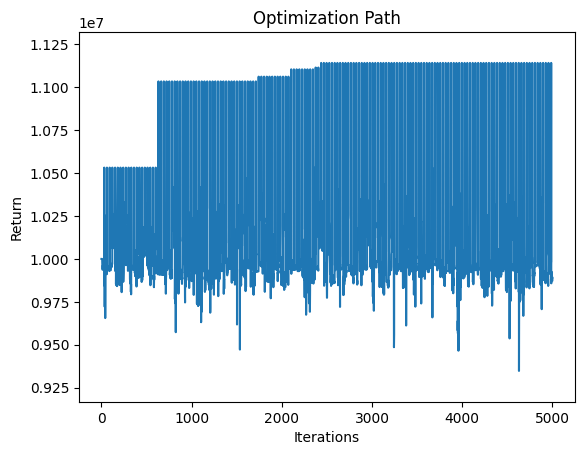

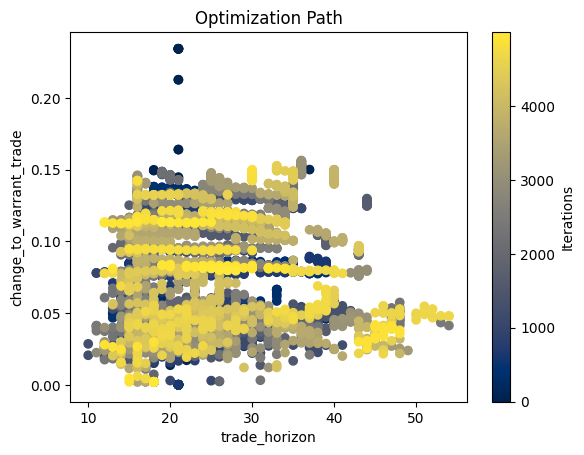

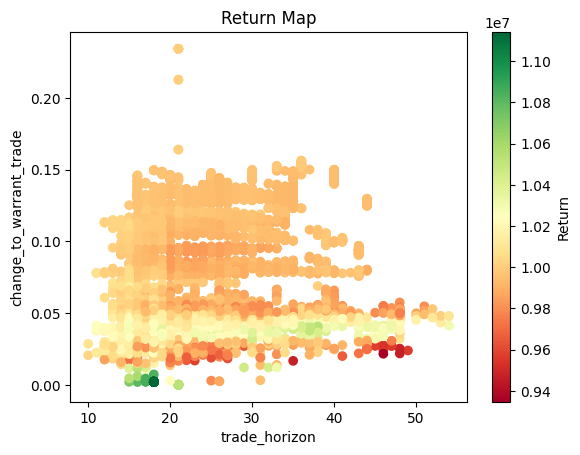

In [48]:
# run optimizer
path = gradient_descent_trading_algorithm_optimizer(arima_trading_algorithm_final_account_value, test_series, predictions, trade_horizon_range, change_to_warrant_trade_range, learning_rate=learning_rate, num_iterations=num_iterations, idle_stop_limit=idle_stop_limit, delta_trade_horizon=.2, delta_change_to_warrant_trade=.03, delta_randomness=.2)
changes_to_warrant_trade, trade_horizons, final_account_values, trade_counts, profitable_trade_ratios = [], [], [], [], []
for i in range(len(path)):
  changes_to_warrant_trade.append(path[i][0][0])
  trade_horizons.append(path[i][0][1])
  final_account_values.append(path[i][1])
  trade_counts.append(path[i][2])
  profitable_trade_ratios.append(round(path[i][3],2))
sorted_data = sorted(set(zip(changes_to_warrant_trade, trade_horizons, final_account_values, trade_counts, profitable_trade_ratios)), key=lambda x: x[2], reverse=True)
top_5 = sorted_data[:5]

print("(c, t): \tfinal value \ttrade count \tprofit ratio \tannualized return (%)")
print("-------------------------------------------------------------------------------")

len_test_series = len(test_series)
i=0
for vals in top_5:
  last_value = round(vals[2])
  trade_count = vals[3]
  profit_ratio = vals[4]
  annual_return = effective_annual_return(10000000, last_value, len_test_series)
  print(f"{round(vals[0],4),vals[1]}: \t{last_value} \t{trade_count} \t\t{profit_ratio} \t\t{annual_return}")
  i+=1

plt.figure()
plt.plot(final_account_values)
plt.title('Optimization Path')
plt.xlabel('Iterations')
plt.ylabel('Return')
min_fac, max_fac = min(final_account_values), max(final_account_values)
extend_fac = (max_fac - min_fac)/10
plt.ylim([min_fac-extend_fac, max_fac+extend_fac])
plt.draw()
plt.show()
color_map = np.arange(len(path))
plt.scatter(trade_horizons, changes_to_warrant_trade, c=color_map, cmap='cividis')
plt.title('Optimization Path')
plt.ylabel('change_to_warrant_trade')
plt.xlabel('trade_horizon')
plt.colorbar(label='Iterations')
plt.show()
plt.scatter(trade_horizons, changes_to_warrant_trade, c=final_account_values, cmap='RdYlGn')
plt.title('Return Map')
plt.ylabel('change_to_warrant_trade')
plt.xlabel('trade_horizon')
plt.colorbar(label='Return')
plt.show()



After lots of tuning, we're able to find a set of approximately optimal parameters.

# Results on more recent data

In [49]:
# import and stitch data
more_recent_nokia_data = '/NOK_daily_20110228_20231130.csv'
more_recent_series = read_csv(datasets_path + more_recent_nokia_data, header=0, index_col=0, parse_dates=True)
stitched_series = pd.concat([series,more_recent_series])
print(stitched_series)

            NOK US Equity Price
Date                           
1995-04-25               2.5625
1995-04-26               2.5547
1995-04-27               2.5313
1995-04-28               2.5625
1995-05-01               2.6719
...                         ...
2023-11-24               3.5500
2023-11-27               3.5400
2023-11-28               3.5200
2023-11-29               3.5600
2023-11-30               3.4800

[7203 rows x 1 columns]


In [50]:
arima_order = (2,1,0)
train_size = .66
X = stitched_series.values
size = int(len(X) * train_size)
test = X[size:]
trade_horizons = []

In [51]:
top_5

[(0.0020654740675837085, 18, 11141259.0, 1210, 0.51),
 (0.0021368109047270184, 18, 11114459.0, 1208, 0.51),
 (0.00221258844551902, 18, 11103959.0, 1207, 0.51),
 (0.0022791219839064436, 18, 11061359.0, 1204, 0.51),
 (0.0023227622557513163, 18, 11033676.0, 1202, 0.51)]

In [52]:
for parameters in top_5:
  trade_horizons.append(parameters[1])
recent_data_predictions = generate_arima_predictions(stitched_series, train_size, arima_order, trade_horizons) # can take a long time

0/2450
1/2450
2/2450
3/2450
4/2450
5/2450
6/2450
7/2450
8/2450
9/2450
10/2450
11/2450
12/2450
13/2450
14/2450
15/2450
16/2450
17/2450
18/2450
19/2450
20/2450
21/2450
22/2450
23/2450
24/2450
25/2450
26/2450
27/2450
28/2450
29/2450
30/2450
31/2450
32/2450
33/2450
34/2450
35/2450
36/2450
37/2450
38/2450
39/2450
40/2450
41/2450
42/2450
43/2450
44/2450
45/2450
46/2450
47/2450
48/2450
49/2450
50/2450
51/2450
52/2450
53/2450
54/2450
55/2450
56/2450
57/2450
58/2450
59/2450
60/2450
61/2450
62/2450
63/2450
64/2450
65/2450
66/2450
67/2450
68/2450
69/2450
70/2450
71/2450
72/2450
73/2450
74/2450
75/2450
76/2450
77/2450
78/2450
79/2450
80/2450
81/2450
82/2450
83/2450
84/2450
85/2450
86/2450
87/2450
88/2450
89/2450
90/2450
91/2450
92/2450
93/2450
94/2450
95/2450
96/2450
97/2450
98/2450
99/2450
100/2450
101/2450
102/2450
103/2450
104/2450
105/2450
106/2450
107/2450
108/2450
109/2450
110/2450
111/2450
112/2450
113/2450
114/2450
115/2450
116/2450
117/2450
118/2450
119/2450
120/2450
121/2450
122/2450
123

In [53]:
recent_data_predictions_copy = recent_data_predictions

In [54]:
recent_data_predictions = recent_data_predictions_copy

In [55]:
trade_horizons = []
account_values = {}
for parameters in top_5:
  change_to_warrant_trade, trade_horizon = parameters[0], parameters[1]
  trade_horizons.append(trade_horizon)
  account_values[(change_to_warrant_trade, trade_horizon)] = arima_trading_algorithm_return_path(test, trade_horizon, recent_data_predictions[trade_horizon], change_to_warrant_trade)


(c, t): 	final value 	trade count 	profit ratio 	annualized return (%)
---------------------------------------------------------------------------------------
(0.0022, 18): 	9490000 	2423 		0.48 		-1.3791
(0.0023, 18): 	9490000 	2423 		0.48 		-1.3791
(0.0023, 18): 	9490000 	2423 		0.48 		-1.3791
(0.0021, 18): 	9484800 	2424 		0.48 		-1.3934
(0.0021, 18): 	9484800 	2424 		0.48 		-1.3934


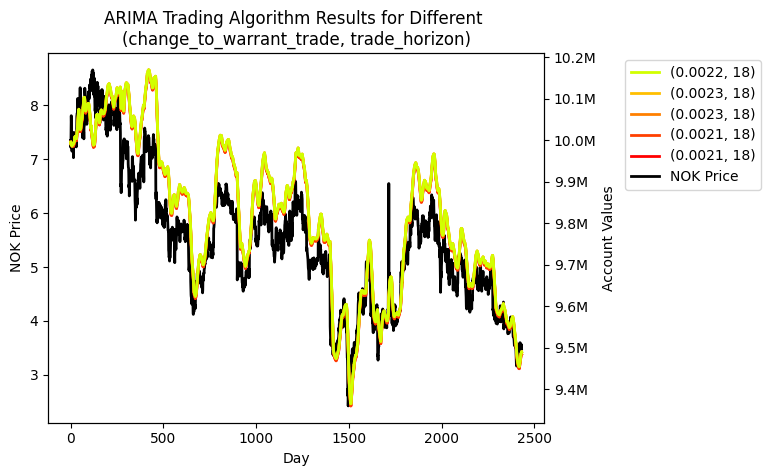

In [56]:
print("(c, t): \tfinal value \ttrade count \tprofit ratio \tannualized return (%)")
print("---------------------------------------------------------------------------------------")
terminal_account_values = {}
for parameter_set in account_values.keys():
  terminal_account_values[parameter_set] = account_values[parameter_set][0][-1]
terminal_account_values = sorted(terminal_account_values.items(), key=lambda item: item[1], reverse=True)
ranked_terminal_account_values = {key: rank for rank, (key, value) in enumerate(terminal_account_values, start=1)}
top_5 = {}
for parameter_set in list(ranked_terminal_account_values.keys())[:8]:
  top_5[parameter_set] = account_values[parameter_set]
account_values = top_5
i = 0
len_test_series = len(test_series)
for parameter_set in account_values:
  last_value = round(account_values[parameter_set][0][-1])
  trade_count = account_values[parameter_set][1]
  profit_ratio = account_values[parameter_set][2]
  annual_return = effective_annual_return(10000000, last_value, len_test_series)
  print(f"{round(parameter_set[0],4),parameter_set[1]}: \t{last_value} \t{trade_count} \t\t{profit_ratio} \t\t{annual_return}")
  i+=1
max_trade_horizon = max(trade_horizons)
for parameter_set in account_values.keys():
  trade_horizon = parameter_set[1]
  account_values[parameter_set] = (account_values[parameter_set][0][max_trade_horizon - trade_horizon:], account_values[parameter_set][1], account_values[parameter_set][2])
test = test[max_trade_horizon:]

usable_colors = ['#ff0000', '#ff4000', '#ff8000', '#ffbf00', '#d2ff00', '#a0ff00', '#6dff00', '#00cc00']
fig, ax1 = plt.subplots()
line_thickness = 2
x_values = np.arange(len(test))
ax1.plot(x_values, test, label='NOK Price', color='black', linewidth=line_thickness)
ax1.set_ylabel('NOK Price', color='black')
ax1.tick_params(axis='y', labelcolor='black')
color = 0
ax2 = ax1.twinx()
for parameter_set in reversed(account_values.keys()):
  ax2.plot(x_values, account_values[parameter_set][0], label=f'{round(parameter_set[0],4),parameter_set[1]}', color=usable_colors[color], linewidth=line_thickness)
  color += 1
ax1.set_xlabel('Day')
ax2.set_ylabel('Account Values')
ax2.tick_params(axis='y')

def millions_formatter(x, pos):
    return f'{x / 1e6}M'
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax2.legend(list(reversed(lines)), list(reversed(labels)), loc='upper left', bbox_to_anchor=(1.15,1))

plt.title('ARIMA Trading Algorithm Results for Different \n(change_to_warrant_trade, trade_horizon)')
plt.show()


# What's next

Next steps:
- refactor so you can plug any prediction model in and have it find optimal parameters
- try this process on a ton of stocks
- select optimal based on average performance over multiple periods
